In [24]:
from zipfile import ZipFile
import pandas as pd
import kaggle
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# https://www.kaggle.com/kimjihoo/coronavirusdataset
kaggle.api.authenticate()
kg_url='kimjihoo/coronavirusdataset'
files=['patient.csv','route.csv','time.csv']

In [156]:
for file in files:
    kaggle.api.dataset_download_file(kg_url,file,force=True, path='data')#force =Trure rewrites file if excist


In [159]:
df_patient = pd.read_csv('data/'+files[0])
df_route = pd.read_csv('data/'+files[1])
df_time = pd.read_csv('data/'+files[2])

In [160]:
df_time.rename(columns={'176':'Date'},inplace=True)
df_time['Date']=pd.to_datetime(df_time['Date'])

In [161]:
df_patient['id'].nunique(), df_patient.shape

(6284, (6285, 14))

In [162]:
df_route['id'].nunique(), df_route.shape

(20, (102, 7))

In [163]:
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6285 entries, 0 to 6284
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                6284 non-null   float64
 1   sex               421 non-null    object 
 2   birth_year        408 non-null    float64
 3   country           6283 non-null   object 
 4   region            409 non-null    object 
 5   group             83 non-null     object 
 6   infection_reason  146 non-null    object 
 7   infection_order   35 non-null     float64
 8   infected_by       70 non-null     float64
 9   contact_number    50 non-null     float64
 10  confirmed_date    6284 non-null   object 
 11  released_date     38 non-null     object 
 12  deceased_date     23 non-null     object 
 13  state             6284 non-null   object 
dtypes: float64(5), object(9)
memory usage: 687.5+ KB


In [164]:
date_clm = ['confirmed_date','released_date','deceased_date']
for clm in date_clm:
    df_patient[clm]=pd.to_datetime(df_patient[clm])

In [165]:
df_patient['duration']=df_patient['released_date']-df_patient['confirmed_date']
df_patient['duration_death']=df_patient['deceased_date']-df_patient['confirmed_date']
df_patient['age'] =2019- df_patient['birth_year']

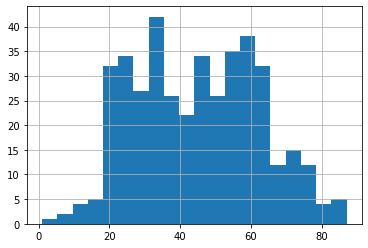

In [166]:
df_patient['age'].hist(bins=20)

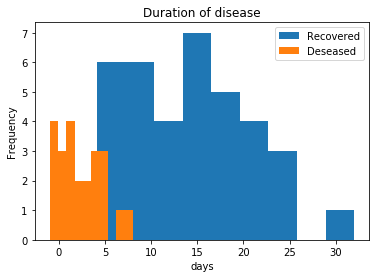

In [167]:
df_patient['duration'].astype('timedelta64[D]').plot.hist(label='Recovered')
df_patient['duration_death'].astype('timedelta64[D]').plot.hist(label='Deseased')
plt.xlabel('days')
plt.legend()
plt.title('Duration of disease')
plt.show()

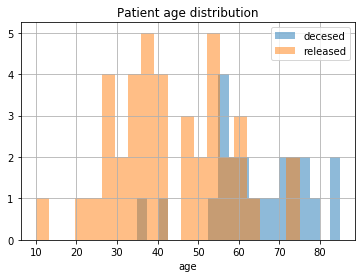

In [168]:
df_patient[df_patient['state']=='deceased']['age'].hist(bins=20,alpha=0.5,label='decesed')
df_patient[df_patient['state']=='released']['age'].hist(bins=20,alpha=0.5,label='released')
plt.xlabel('age')
plt.title('Patient age distribution')
plt.legend();

In [174]:
df_time=df_time.set_index('Date')


KeyError: "None of ['Date'] are in the columns"

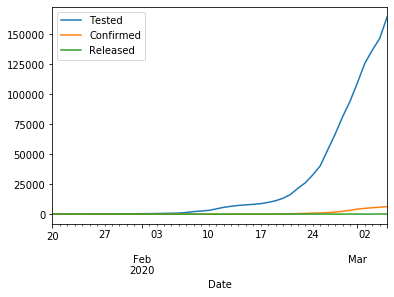

In [181]:
df_time['acc_test'].plot(label='Tested')
df_time['acc_confirmed'].plot(label='Confirmed')
df_time['acc_released'].plot(label='Released')
plt.legend()
